In [55]:
import glob
import pprint
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Blast.Applications import NcbimakeblastdbCommandline
from Bio.Blast.Applications import NcbiblastpCommandline
from Bio.Blast import NCBIXML


In [56]:
# okay so I have a list of known pfam types thanks to S. Casjens.
# I need to pull all of the annotated pfam32 domains from the annotated contigs
# then I need to figure out the edit/levenshtein distance between the annotated pfam32 and the known reference
# then I need to figure out the closest match for each annotated pfam32 domain

# first I need to read in the pfam32 domains from the annotated contigs
# I have already done this for ospC. I shall include that below
## ACTUALLY I NEED TO FUNCTIONALIZE THESE STEPS!

[pfam32 reference article, Casjens et al (2012)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0033280)

In [131]:
assemblies = glob.glob("/Users/mf019/bioinformatics/longread_GWAS/assemblies/nanopore/annotation/*/*.gbff")
print(assemblies)
testing_set_file = 'Minimal-PF32-testor-set-March2021.faa'
pfam32_name = "parA"

['/Users/mf019/bioinformatics/longread_GWAS/assemblies/nanopore/annotation/5A18NP1-JBb08-E/5A18NP1-JBb08-E.gbff', '/Users/mf019/bioinformatics/longread_GWAS/assemblies/nanopore/annotation/5A18NP1-JBb08-B/5A18NP1-JBb08-B.gbff', '/Users/mf019/bioinformatics/longread_GWAS/assemblies/nanopore/annotation/5A18NP1-JBb08-C/5A18NP1-JBb08-C.gbff', '/Users/mf019/bioinformatics/longread_GWAS/assemblies/nanopore/annotation/5A18NP1-JBb08-D/5A18NP1-JBb08-D.gbff', '/Users/mf019/bioinformatics/longread_GWAS/assemblies/nanopore/annotation/BL091_B31E2_erpP/BL091_B31E2_erpP.gbff', '/Users/mf019/bioinformatics/longread_GWAS/assemblies/nanopore/annotation/B31-K2/B31-K2.gbff', '/Users/mf019/bioinformatics/longread_GWAS/assemblies/nanopore/annotation/5A18NP1-JBb08-A/5A18NP1-JBb08-A.gbff', '/Users/mf019/bioinformatics/longread_GWAS/assemblies/nanopore/annotation/N40_HP/N40_HP.gbff', '/Users/mf019/bioinformatics/longread_GWAS/assemblies/nanopore/annotation/BB-8/BB-8.gbff', '/Users/mf019/bioinformatics/longread_

In [132]:
# now lets get that file into a single Bio seqrecord dict

def fasta_to_dict(fasta_file):
    fasta_dict = SeqIO.to_dict(SeqIO.parse(fasta_file, "fasta"))
    return(fasta_dict)

def parse_blast_results(blast_results : str) -> dict:
    file_size = os.path.getsize(blast_results)
    if file_size == 0:
        return None
    results = {}
    with open(blast_results, "r") as f:
        blast_records = NCBIXML.parse(f)
        for record in blast_records:
            results[record.query] = []
            for alignment in record.alignments:
                for hsp in alignment.hsps:
                    results[record.query].append((alignment.title, hsp.expect, hsp.score,))
    return results

In [133]:
pf32_dict = fasta_to_dict(testing_set_file)
pf32_db = "pf32_db/pf32"
# now to make blastDB
makeblastdb_cmd = NcbimakeblastdbCommandline(input_file=testing_set_file, dbtype="prot", out=pf32_db)
print(makeblastdb_cmd)
stdout, stderr = makeblastdb_cmd()


makeblastdb -out pf32_db/pf32 -dbtype prot -in Minimal-PF32-testor-set-March2021.faa


In [153]:
parA_genes = {}
for file in assemblies:
    print(file)
    sample_id = file.split("/")[-1].split(".")[0]
    parA_genes[sample_id] = []
    with open(file, "r") as f:
        record = SeqIO.parse(f, "genbank")
        for rec in record:
            #print(rec.id)
            for feature in rec.features:
                if feature.type == "CDS":
                    product = feature.qualifiers['product']
                    if "ParA" in product[0]:
                        #print(rec.id, product)
                        feature.qualifiers['product']
                        # get sequence
                        #print(feature.location)
                        # Now lets make a new SeqRecord object for the gene and append it to our list of OspC Genes!
                        nucseq = feature.extract(rec.seq)
                        if len(nucseq) % 3 != 0:
                            print(f"Sequence length not divisible by 3 for {rec.id}---{sample_id}")
                            nucseq += "N"
                            print("adding N!")
                        else:
                            protseq = nucseq.translate(table=11, to_stop=True)
                            gene = SeqIO.SeqRecord(protseq, id=f"{sample_id}-{rec.id}-ParA", name=product[0], description=f"{rec.id}---{sample_id}", dbxrefs=None)
                            parA_genes[sample_id].append(gene)

/Users/mf019/bioinformatics/longread_GWAS/assemblies/nanopore/annotation/5A18NP1-JBb08-E/5A18NP1-JBb08-E.gbff
/Users/mf019/bioinformatics/longread_GWAS/assemblies/nanopore/annotation/5A18NP1-JBb08-B/5A18NP1-JBb08-B.gbff
/Users/mf019/bioinformatics/longread_GWAS/assemblies/nanopore/annotation/5A18NP1-JBb08-C/5A18NP1-JBb08-C.gbff
/Users/mf019/bioinformatics/longread_GWAS/assemblies/nanopore/annotation/5A18NP1-JBb08-D/5A18NP1-JBb08-D.gbff
/Users/mf019/bioinformatics/longread_GWAS/assemblies/nanopore/annotation/BL091_B31E2_erpP/BL091_B31E2_erpP.gbff
/Users/mf019/bioinformatics/longread_GWAS/assemblies/nanopore/annotation/B31-K2/B31-K2.gbff
/Users/mf019/bioinformatics/longread_GWAS/assemblies/nanopore/annotation/5A18NP1-JBb08-A/5A18NP1-JBb08-A.gbff
/Users/mf019/bioinformatics/longread_GWAS/assemblies/nanopore/annotation/N40_HP/N40_HP.gbff
/Users/mf019/bioinformatics/longread_GWAS/assemblies/nanopore/annotation/BB-8/BB-8.gbff
/Users/mf019/bioinformatics/longread_GWAS/assemblies/nanopore/anno

In [154]:
pprint.pprint(parA_genes)

{'5A18NP1-JBb08-A': [SeqRecord(seq=Seq('MDRKKSNIITIANLKGGVGKSTLSILFSYVLKDLGKKVLLIDMDSQNALTSYFR...LDL'), id='5A18NP1-JBb08-A-contig_1-ParA', name='ParA-like ATPase involved in chromosome/plasmid partitioning or cellulose biosynthesis protein BcsQ', description='contig_1---5A18NP1-JBb08-A', dbxrefs=[]),
                     SeqRecord(seq=Seq('MDNKKPKIITIASIKGGVGKSTSALFYGNILAKERHKVLIIDSDPQASITSYFL...KIK'), id='5A18NP1-JBb08-A-contig_2-ParA', name='ParA-like ATPase involved in chromosome/plasmid partitioning or cellulose biosynthesis protein BcsQ', description='contig_2---5A18NP1-JBb08-A', dbxrefs=[]),
                     SeqRecord(seq=Seq('MDNKKPKIITIASIKGGVGKSTSAIIFATLLAQKYKVLLIDIDTQASTTSYYYD...KLK'), id='5A18NP1-JBb08-A-contig_5-ParA', name='ParA-like ATPase involved in chromosome/plasmid partitioning or cellulose biosynthesis protein BcsQ', description='contig_5---5A18NP1-JBb08-A', dbxrefs=[]),
                     SeqRecord(seq=Seq('MDNKKPKIITIASIKGGVGKSTSAIIFTTLLSQDWKVLLIDMDTQASVTSY

In [157]:
with open('parA_genes_query.faa', 'w') as out:
    for sample in parA_genes:
        for gene in parA_genes[sample]:
            print(gene)
            SeqIO.write(gene, out, "fasta")

ID: 5A18NP1-JBb08-E-contig_1-ParA
Name: ParA-like ATPase involved in chromosome/plasmid partitioning or cellulose biosynthesis protein BcsQ
Description: contig_1---5A18NP1-JBb08-E
Number of features: 0
Seq('MDRKKTEIITIASVKGGVGKSALAIIFSYILKNFNKKVLLVDLDPQNSLTSYFI...KVR')
ID: 5A18NP1-JBb08-E-contig_1-ParA
Name: ParA-like ATPase involved in chromosome/plasmid partitioning or cellulose biosynthesis protein BcsQ
Description: contig_1---5A18NP1-JBb08-E
Number of features: 0
Seq('MDRKKTEIITIASVKGGVGKSALAIIFSYILKNFNKKVLLVDLDPQNSLTSYFI...KVR')
ID: 5A18NP1-JBb08-E-contig_1-ParA
Name: ParA family protein
Description: contig_1---5A18NP1-JBb08-E
Number of features: 0
Seq('MDIKKPDIIALTSVKGGVGKSTLSILFSYLLKELGKKILLIDLDPQNSLTSYFT...FSL')
ID: 5A18NP1-JBb08-E-contig_1-ParA
Name: ParA family protein
Description: contig_1---5A18NP1-JBb08-E
Number of features: 0
Seq('MDIKKPDIIALTSVKGGVGKSTLSILFSYLLKELGKKILLIDLDPQNSLTSYFT...FSL')
ID: 5A18NP1-JBb08-E-contig_1-ParA
Name: ParA-like ATPase involved in chromosome/

In [158]:
# now lets blast our sequences against the pf32 database we just made!
parA_blast_out = "parA_blast_out.xml"
parA_blast_cmd = NcbiblastpCommandline(query="parA_genes_query.faa", db=pf32_db, out=parA_blast_out, outfmt=5)
print(parA_blast_cmd)
stdout, stderr = parA_blast_cmd()

blastp -out parA_blast_out.xml -outfmt 5 -query parA_genes_query.faa -db pf32_db/pf32


In [159]:
plasmid_content_asm = {}
for file in assemblies:
    print(file)
    sample_id = file.split("/")[-1].split(".")[0]
    parA_genes[sample_id] = []
    plasmid_content_asm[sample_id] = {}
    with open(file, "r") as f:
        record = SeqIO.parse(f, "genbank")
        for rec in record:
            print(rec.id, len(rec.seq))
            plasmid_content_asm[sample_id][rec.id] = {"len" : len(rec.seq), "plasmid" : "", "pfam32_type" : ""}

/Users/mf019/bioinformatics/longread_GWAS/assemblies/nanopore/annotation/5A18NP1-JBb08-E/5A18NP1-JBb08-E.gbff
contig_1 62461
contig_2 77760
contig_3 57257
contig_4 45923
contig_5 73551
contig_6 44062
contig_7 91299
contig_8 48122
contig_9 33741
contig_10 44317
contig_11 50927
contig_12 27362
contig_13 46434
contig_14 15253
contig_15 60129
contig_16 71759
contig_17 60115
contig_18 933400
contig_19 18712
contig_20 31256
/Users/mf019/bioinformatics/longread_GWAS/assemblies/nanopore/annotation/5A18NP1-JBb08-B/5A18NP1-JBb08-B.gbff
contig_1 45296
contig_2 17879
contig_3 40797
contig_4 38703
contig_5 43097
contig_6 19706
contig_7 916785
contig_8 43158
contig_9 77536
contig_10 56100
contig_11 18350
contig_12 42520
contig_13 10629
contig_14 61014
contig_15 48117
contig_16 28253
contig_17 39067
contig_18 27850
contig_19 70516
contig_20 55408
contig_21 26439
contig_22 10784
contig_23 92658
contig_24 17241
/Users/mf019/bioinformatics/longread_GWAS/assemblies/nanopore/annotation/5A18NP1-JBb08-C/5A1

In [160]:
pprint.pprint(plasmid_content_asm)

{'5A18NP1-JBb08-A': {'contig_1': {'len': 21131,
                                  'pfam32_type': '',
                                  'plasmid': ''},
                     'contig_10': {'len': 54022,
                                   'pfam32_type': '',
                                   'plasmid': ''},
                     'contig_11': {'len': 84859,
                                   'pfam32_type': '',
                                   'plasmid': ''},
                     'contig_12': {'len': 17373,
                                   'pfam32_type': '',
                                   'plasmid': ''},
                     'contig_13': {'len': 45690,
                                   'pfam32_type': '',
                                   'plasmid': ''},
                     'contig_14': {'len': 37809,
                                   'pfam32_type': '',
                                   'plasmid': ''},
                     'contig_15': {'len': 94733,
                              

In [161]:
# now lets parse our blast results
results = parse_blast_results(parA_blast_out)
for query in results:
    query_id = query.split(" ")
    contig_id = query_id[1].split("---")[0]
    sample_id = query_id[1].split("---")[1]
    print(query_id, contig_id, sample_id)
    hit = results[query][0]
    #print(hit)
    hit_id = hit[0].split(" ")[1].split("_")[-1]
    print(sample_id, contig_id, hit_id)
    plasmid_content_asm[sample_id][contig_id]["pfam32_type"] = hit_id

['5A18NP1-JBb08-E-contig_1-ParA', 'contig_1---5A18NP1-JBb08-E'] contig_1 5A18NP1-JBb08-E
5A18NP1-JBb08-E contig_1 lp28-1-geneF24
['5A18NP1-JBb08-E-contig_2-ParA', 'contig_2---5A18NP1-JBb08-E'] contig_2 5A18NP1-JBb08-E
5A18NP1-JBb08-E contig_2 lp38
['5A18NP1-JBb08-E-contig_3-ParA', 'contig_3---5A18NP1-JBb08-E'] contig_3 5A18NP1-JBb08-E
5A18NP1-JBb08-E contig_3 lp28-3
['5A18NP1-JBb08-E-contig_4-ParA', 'contig_4---5A18NP1-JBb08-E'] contig_4 5A18NP1-JBb08-E
5A18NP1-JBb08-E contig_4 cp32-8
['5A18NP1-JBb08-E-contig_5-ParA', 'contig_5---5A18NP1-JBb08-E'] contig_5 5A18NP1-JBb08-E
5A18NP1-JBb08-E contig_5 lp36
['5A18NP1-JBb08-E-contig_6-ParA', 'contig_6---5A18NP1-JBb08-E'] contig_6 5A18NP1-JBb08-E
5A18NP1-JBb08-E contig_6 cp32-6
['5A18NP1-JBb08-E-contig_7-ParA', 'contig_7---5A18NP1-JBb08-E'] contig_7 5A18NP1-JBb08-E
5A18NP1-JBb08-E contig_7 lp54
['5A18NP1-JBb08-E-contig_8-ParA', 'contig_8---5A18NP1-JBb08-E'] contig_8 5A18NP1-JBb08-E
5A18NP1-JBb08-E contig_8 cp32-4
['5A18NP1-JBb08-E-contig_10-Pa

In [162]:
pprint.pprint(plasmid_content_asm)

{'5A18NP1-JBb08-A': {'contig_1': {'len': 21131,
                                  'pfam32_type': 'lp38',
                                  'plasmid': ''},
                     'contig_10': {'len': 54022,
                                   'pfam32_type': 'cp32-8',
                                   'plasmid': ''},
                     'contig_11': {'len': 84859,
                                   'pfam32_type': 'lp36',
                                   'plasmid': ''},
                     'contig_12': {'len': 17373,
                                   'pfam32_type': '',
                                   'plasmid': ''},
                     'contig_13': {'len': 45690,
                                   'pfam32_type': 'cp26',
                                   'plasmid': ''},
                     'contig_14': {'len': 37809,
                                   'pfam32_type': 'cp32-4',
                                   'plasmid': ''},
                     'contig_15': {'len': 94733,
      

In [163]:
plasmids_per_sample = {}
for sample in plasmid_content_asm:
    plasmids_per_sample[sample] = []
    for contig in plasmid_content_asm[sample]:
        #print(sample, contig, plasmid_content_asm[sample][contig]["pfam32_type"], plasmid_content_asm[sample][contig]["len"])
        plasmids_per_sample[sample].append(plasmid_content_asm[sample][contig]["pfam32_type"])

In [164]:
pprint.pprint(plasmids_per_sample)

{'5A18NP1-JBb08-A': ['lp38',
                     'cp32-9',
                     '',
                     '',
                     'cp32-6',
                     'cp32-7',
                     'lp54',
                     'cp32-1',
                     '',
                     'cp32-8',
                     'lp36',
                     '',
                     'cp26',
                     'cp32-4',
                     'lp38',
                     'lp28-3',
                     'lp38',
                     'lp56',
                     'lp28-1-geneF24'],
 '5A18NP1-JBb08-B': ['cp32-9',
                     'cp32-1',
                     '',
                     'cp32-7',
                     'cp32-4',
                     'cp32-1',
                     'lp56',
                     'lp28-1-geneF24',
                     'lp36',
                     'lp25',
                     '',
                     'cp26',
                     '',
                     'lp38',
                     'lp28

In [165]:
for sample in plasmids_per_sample:
    print(sample, set(plasmids_per_sample[sample]), len(set(plasmids_per_sample[sample])))

5A18NP1-JBb08-E {'', 'lp28-3', 'cp32-9', 'cp32-7', 'lp56', 'lp36', 'lp28-1-geneF24', 'cp32-4', 'lp38', 'cp26', 'lp25', 'cp32-3', 'cp32-1', 'lp54', 'cp32-8', 'cp32-6'} 16
5A18NP1-JBb08-B {'', 'cp32-9', 'cp32-7', 'lp28-3', 'lp56', 'lp36', 'cp32-4', 'lp28-1-geneF24', 'lp25', 'cp26', 'lp38', 'cp32-3', 'cp32-1', 'lp54', 'cp32-6'} 15
5A18NP1-JBb08-C {'', 'cp32-9', 'cp32-7', 'lp28-3', 'lp56', 'lp36', 'cp32-4', 'lp38', 'cp26', 'lp25', 'cp32-1', 'lp54', 'cp32-6', 'cp32-8', 'lp28-11'} 15
5A18NP1-JBb08-D {'', 'cp32-9', 'cp32-7', 'lp28-3', 'lp56', 'lp36', 'cp32-4', 'cp32-3', 'cp26', 'lp25', 'lp38', 'lp28-1-geneF24', 'cp32-1', 'lp54', 'cp32-6', 'cp32-8'} 16
BL091_B31E2_erpP {'', 'cp32-3', 'cp26', 'lp28-2', 'lp28-6', 'cp32-1', 'lp54'} 7
B31-K2 {'', 'cp32-9', 'cp32-7', 'lp28-4', 'lp28-3', 'lp56', 'lp36', 'cp32-4', 'cp32-3', 'lp38', 'lp28-2', 'lp25', 'cp26', 'lp54', 'cp32-6', 'cp32-8', 'lp28-11'} 17
5A18NP1-JBb08-A {'', 'cp32-9', 'cp32-7', 'lp28-3', 'lp56', 'lp36', 'cp32-4', 'lp28-1-geneF24', 'lp38', 

In [166]:
#for sample in plasmid_content_asm:
#    for contig in plasmid_content_asm[sample]:
#        print(sample, contig, plasmid_content_asm[sample][contig]["pfam32_type"], plasmid_content_asm[sample][contig]["len"])

In [167]:
# okay so now we have the pfam32 type for each contig in each sample sort of
# now we need to output this into a table
# sample, contig, pfam32_type, plasmid_length

for sample in plasmid_content_asm:
    with open(f"{sample}_plasmid_content.tsv", "w") as out:
        out.write("contig\tpfam32_type\tplasmid_length\n")
        for contig in plasmid_content_asm[sample]:
            out.write(f"{contig}\t{plasmid_content_asm[sample][contig]['pfam32_type']}\t{plasmid_content_asm[sample][contig]['len']}\n")

/Users/mf019/bin/software/conda/miniforge3_x86/envs/blast/lib/python3.9/site-packages/Bio/Phylo/_utils.py:478: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axes.set_xlim(-0.05 * xmax, 1.25 * xmax)


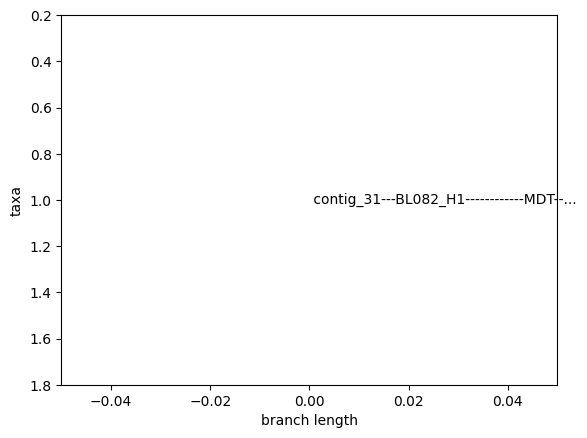

In [197]:
import matplotlib.pyplot as plt
from Bio import Phylo

# Read the MAFFT output file
mafft_output_file = "parA_mafft.out"
tree = Phylo.read(mafft_output_file, "newick")

# Plot the phylogenetic tree
Phylo.draw(tree)
plt.show()

